# Tracking task analysis

This notebook contains code for computing descriptive statistics of the data on the tracking task collected during the first ICUA experiment. 

These descriptives include:
* Mean squared error (performance) - distance of the target from the task center, with hist plots.
* Performance analysis over MSE performance with/without agent guidance.
* Other performance statistics - response time, time to look, 

__MSE performance__ is computed simply `sqrt(P**2).mean()` where `P = (x_i, y_i)` for all `i` (positions of the tracking target during a trial).

MSE performance is checked for normality (it is not - more like a Weibull distribution) using



In [2]:
%matplotlib notebook
import icua_analysis as ia
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.cm as cm

def plot_intervals(intervals, ax=None, alpha=0.25, color='red'):
    if ax is None:
        ax = plt.gca()
    for interval in intervals:
        ax.axvspan(*interval, alpha=alpha, color=color, linewidth=0)
        

### Tracking Task descriptives

<IPython.core.display.Javascript object>


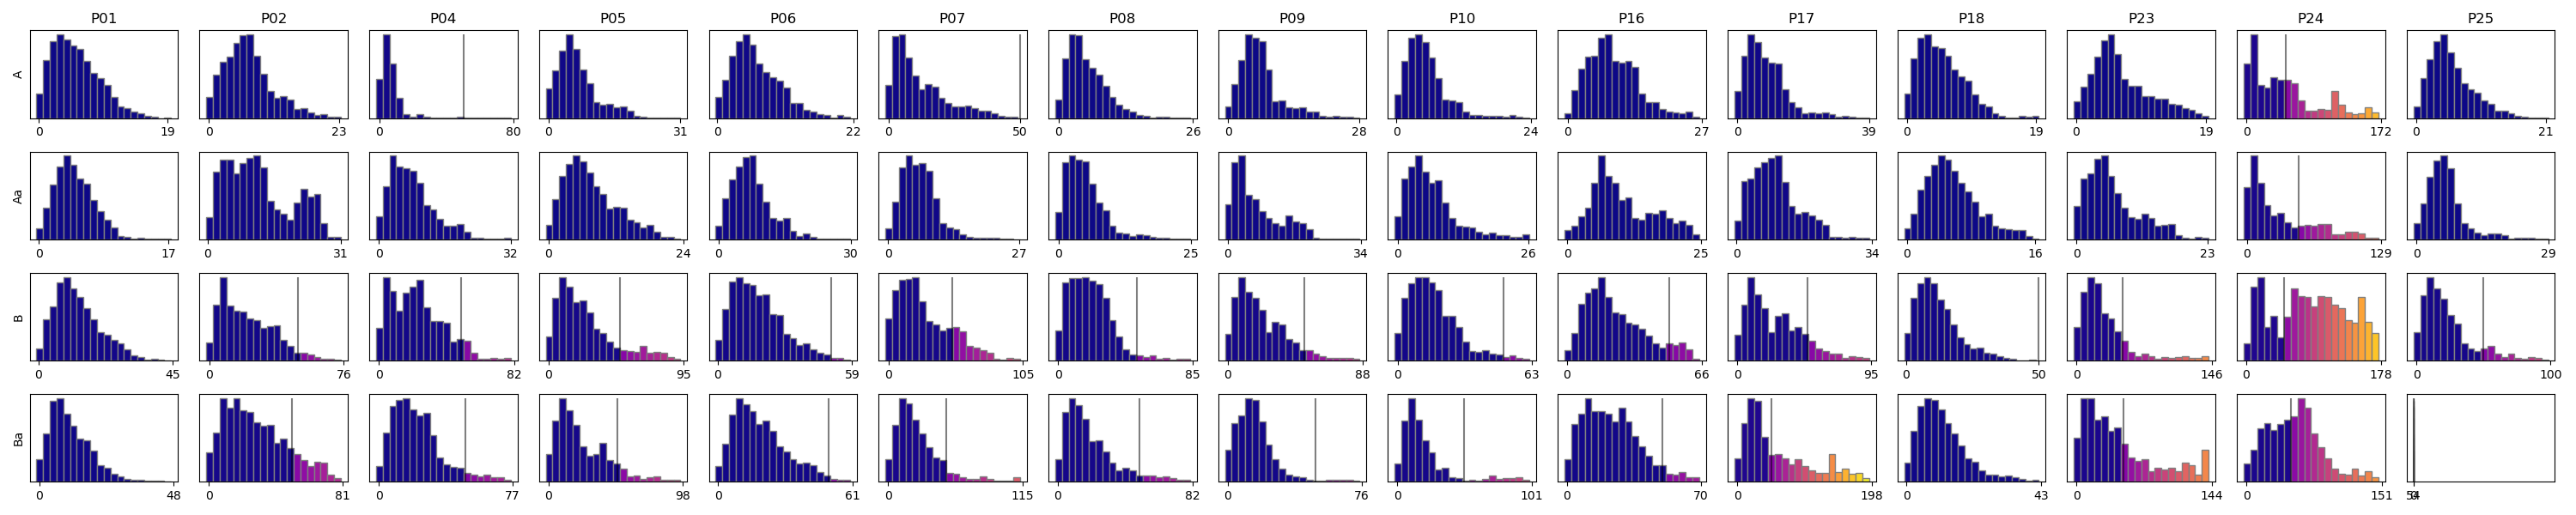

Auci
Aauci
Buci
Bauci


In [14]:
# performance for the tracking task
# hist plots show distance from the center of the tracking task
import itertools
import icua_analysis as ia
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Function to plot a histogram where color of each bar represents its x-value
def plot_color_histogram(ax, data, cmap, vmin, vmax, bins=20, ylim=None, failure_bound=50):
    # Compute the histogram data
    counts, bins = np.histogram(data, bins=bins, density=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    # Normalize the bin centers to the global range of the data
    norm = plt.Normalize(vmin, vmax)
    # Map the bin centers to the colormap
    colors = cmap(norm(bin_centers))
    # plot failure bound
    if data.max() > failure_bound:
        ax.vlines([failure_bound], 0, counts.max(), color="black", alpha=0.5)
    # Plot each bar individually
    for c, p, color in zip(counts, bins, colors):
        color = color if p > failure_bound else colors[0]
        ax.bar(p, c, width=bins[1] - bins[0], color=color, edgecolor='grey', )
    # Set axis ticks
    ax.set_xticks([0, int(bins[-1])])
    ax.set_yticks([])
    if ylim is not None:
        ax.set_ylim(0, ylim)
    
cmap = cm.plasma
dataset = [(x[0], x[1]['tracking_data']) for x in ia.load_tabularised().has_eyetracking()]
vmin, vmax = min([x[1]['score'].min() for x in dataset]), max([x[1]['score'].max() for x in dataset])

fig, axes = plt.subplots(figsize = (30, 6), ncols=len(dataset) // 4, nrows=4)

trial_order = ['icuA', 'icuaA', 'icuB', 'icuaB']
trial_sorting_fun = lambda x: trial_order.index(x[0][1])
trial_grouping_fun = lambda x : x[0][1]

for i, (trial, tgroup) in enumerate(itertools.groupby(sorted(dataset, key=trial_sorting_fun), trial_grouping_fun)):
    axes_row = axes[i]
    for ax, ((par, _), data) in zip(axes_row, tgroup):
        plot_color_histogram(ax, data['score'], cmap=cmap, vmin=vmin, vmax=vmax)
        if i == 0:
            ax.set_title(par)
    print(trial[::-1])
    axes_row[0].set_ylabel(trial[::-1][:-3])

plt.tight_layout()
plt.savefig("../result/tracking_performance_histograms.png")

(30194,) (30339,)
A: 457291096.500 & 0.732 \\ \hline 
B: 634991014.500 & 0.000 \\ \hline 


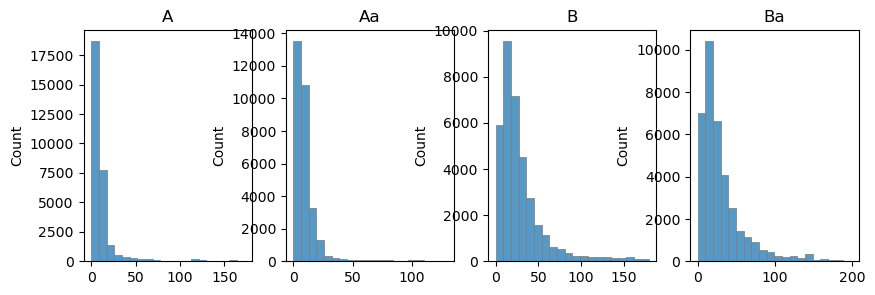

In [31]:
# check normality of MSE performance and perform the wilcoxen t-test (dependent).
import icua_analysis as ia
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sb


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
axes = iter(axes.ravel())

scores = dict()

for trial, par_data in ia.load_tabularised().has_eyetracking().groupby_trial():
    ax = next(axes)
    score = np.concatenate([data['tracking_data']['score'].to_numpy() for data in par_data.values()])
    sb.histplot(score, ax=ax, bins=20, edgecolor="grey")
    ax.set_title(trial[::-1][:-3])
    scores[trial[::-1][:-3]] = score

    
A, Aa = scores['A'], scores['Aa']
B, Ba = scores['B'], scores['Ba']

print(A.shape, Aa.shape)

mannwhitneyuA = stats.mannwhitneyu(A, Aa)
mannwhitneyuB = stats.mannwhitneyu(B, Ba)
print(f"A: {mannwhitneyuA.statistic:.3f} & {mannwhitneyuA.pvalue:.3f} \\\\ \hline ")
print(f"B: {mannwhitneyuB.statistic:.3f} & {mannwhitneyuB.pvalue:.3f} \\\\ \hline ")



    
    
    



In [ ]:
# check for practice effects (improvement over time)

import icua_analysis as ia
import numpy as np
import matplotlib.pyplot as plt

# check for trends using linear regression
import statsmodels.api as sm
# check for trends (practice effect)
import pymannkendall as mk
# check for auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

def mannkendall_tests(x, name):
    t1 = mk.original_test(score) # doesnt correct for auto-correlation
    t2 = mk.pre_whitening_modification_test(score) # corrects for auto-correlation
    t3 = mk.hamed_rao_modification_test(score) # corrects for auto-correlation 
    ts = [t1, t2, t3]
    print(name)
    for t in ts:
        print(f"{type(t).__name__:<60} trend: {t.trend:<10} slope: {t.slope:8.5f} p-value: {t.p:.5f}")
        
demo = ia.load_demographics()

for par, trial_data in ia.load_tabularised().has_eyetracking().groupby_participant():
    # sort by the order that the trials were done for each participant
    trial_order = list(demo[demo['participant'] == par].iloc[0][['T0', 'T1', 'T2', 'T3']])
    trial_data = sorted(trial_data.items(), key = lambda x: trial_order.index(x[0]))
    
    # testing for "within-trial" practice effects - that is, do individual participants improve during a trial?
    for trial, data in trial_data:
        score = data['tracking_data']['failure']
        
        
        
        ## linear regression 
        # X = sm.add_constant(np.arange(len(score)) /  len(score)) # add y-intercept term
        # model = sm.OLS(score, X).fit()
        # print(model.summary())
        
        ## plot auto-correlation
        # plt.figure(figsize=(12,3))
        # plot_acf(score, lags=np.arange(100), ax = plt.gca())
        # plt.show()
        ## plot score
        # plt.figure(figsize=(12,3))
        # plt.gca().plot(score)
        # plt.show()
        
        # mannkendall_tests(score, (par, trial))
 
    
    # testing for "across-trial" practice effects - do individual participants improve across all trials?
    def get_score(data):
        score = data['tracking_data']['score']
        return (score - score.mean()) / score.std()
    score = np.concatenate([get_score(data) for _, data in trial_data])
    
    ## linear regression 
    # X = sm.add_constant(np.arange(len(score)) /  len(score)) # add y-intercept term
    # model = sm.OLS(score, X).fit()
    # print(model.summary())

    ## plot auto-correlation
    # plt.figure(figsize=(12,3))
    # plot_acf(score, lags=np.arange(100), ax = plt.gca())
    # plt.show()
    ## plot score
    plt.figure(figsize=(12,3))
    plt.gca().plot(score)
    plt.show()
        
    mannkendall_tests(score, (par, trial))
    
    


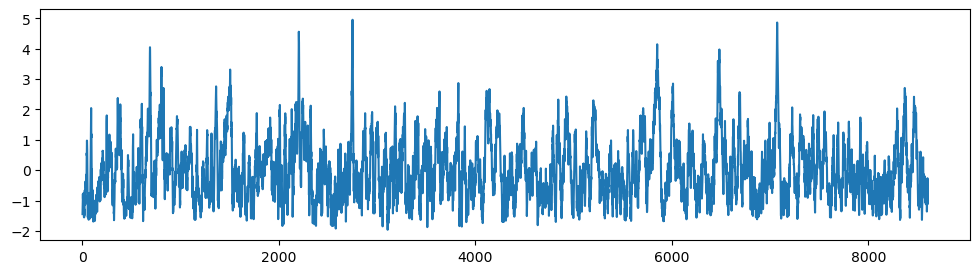

('P01', 'icuaB')
Mann_Kendall_Test                                            trend: no trend   slope:  0.00000 p-value: 0.89826
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00000 p-value: 0.65411
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00000 p-value: 0.95482


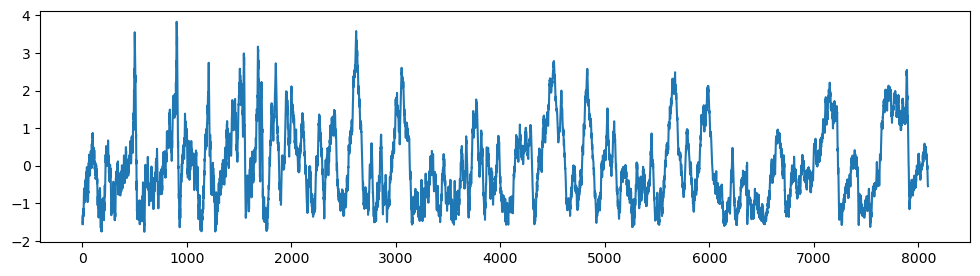

('P02', 'icuaA')
Mann_Kendall_Test                                            trend: no trend   slope: -0.00000 p-value: 0.47699
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00000 p-value: 0.46630
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00000 p-value: 0.88827


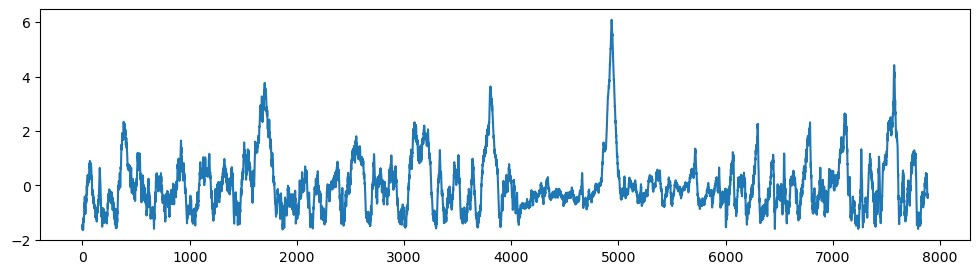

('P04', 'icuaA')
Mann_Kendall_Test                                            trend: increasing slope:  0.00001 p-value: 0.00327
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00001 p-value: 0.21884
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00001 p-value: 0.32034


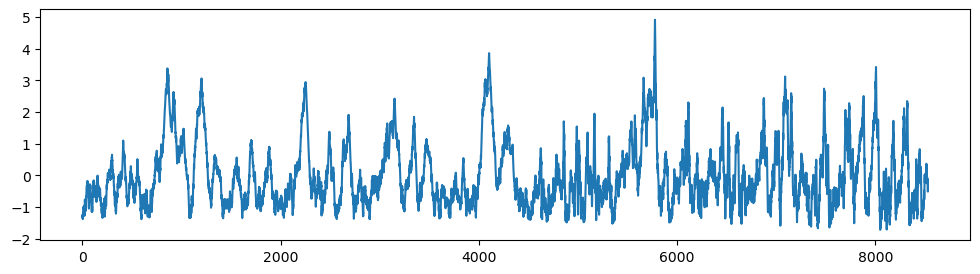

('P05', 'icuaA')
Mann_Kendall_Test                                            trend: increasing slope:  0.00001 p-value: 0.01833
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00001 p-value: 0.17078
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00001 p-value: 0.49137


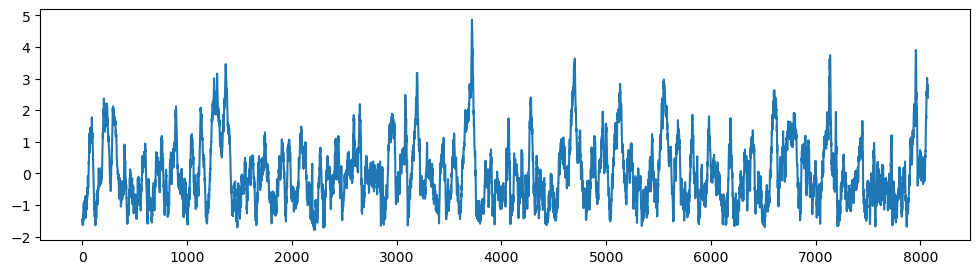

('P06', 'icuA')
Mann_Kendall_Test                                            trend: no trend   slope:  0.00000 p-value: 0.84109
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00000 p-value: 0.77008
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00000 p-value: 0.90442


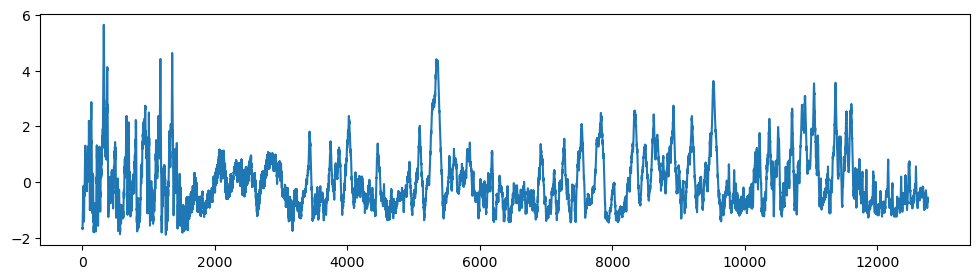

('P07', 'icuA')
Mann_Kendall_Test                                            trend: no trend   slope:  0.00000 p-value: 0.22843
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00000 p-value: 0.49131
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00000 p-value: 0.83457


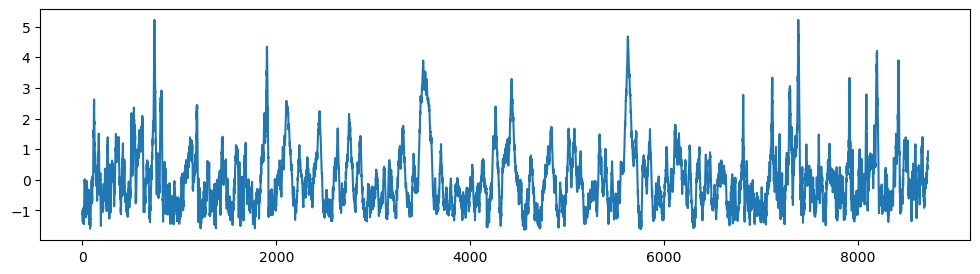

('P08', 'icuaA')
Mann_Kendall_Test                                            trend: no trend   slope:  0.00000 p-value: 0.78191
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00000 p-value: 0.76084
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00000 p-value: 0.90745


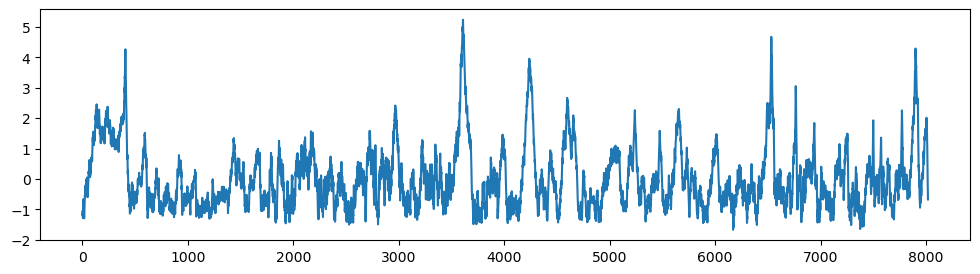

('P09', 'icuA')
Mann_Kendall_Test                                            trend: no trend   slope: -0.00000 p-value: 0.90996
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00000 p-value: 0.96418
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00000 p-value: 0.97661


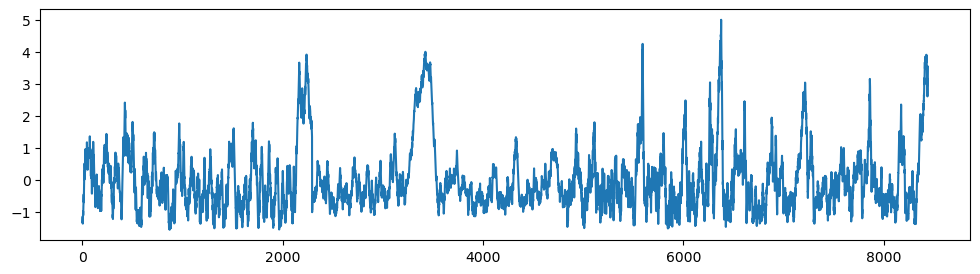

('P10', 'icuaA')
Mann_Kendall_Test                                            trend: no trend   slope:  0.00000 p-value: 0.34721
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00000 p-value: 0.19883
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00000 p-value: 0.78226


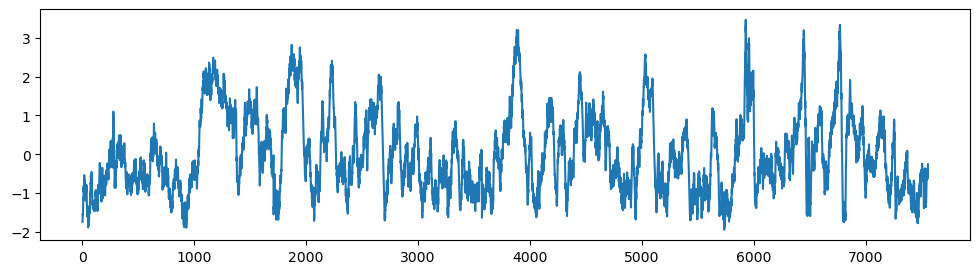

('P16', 'icuA')
Mann_Kendall_Test                                            trend: no trend   slope: -0.00001 p-value: 0.06613
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00001 p-value: 0.90371
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00001 p-value: 0.77226


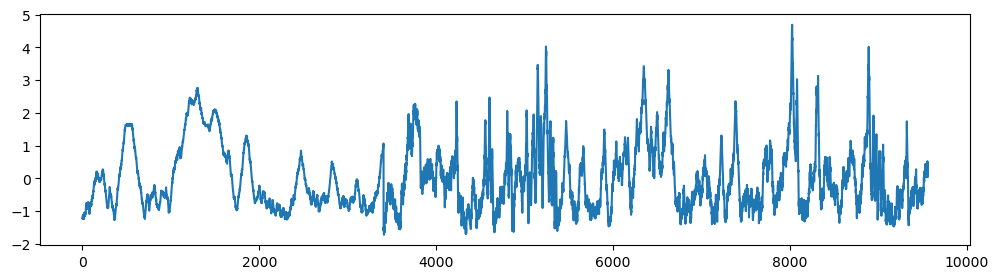

('P17', 'icuA')
Mann_Kendall_Test                                            trend: decreasing slope: -0.00001 p-value: 0.00834
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00001 p-value: 0.19850
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00001 p-value: 0.65439


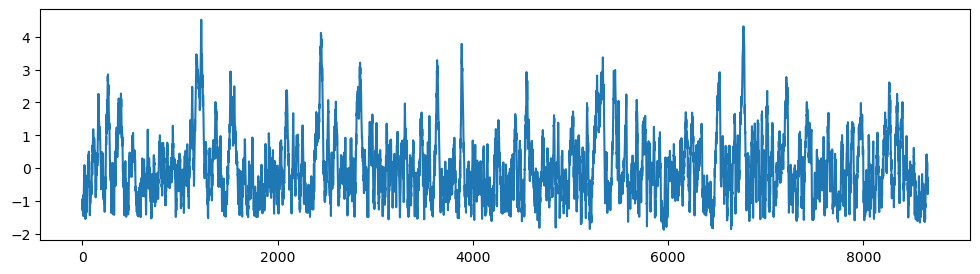

('P18', 'icuA')
Mann_Kendall_Test                                            trend: decreasing slope: -0.00001 p-value: 0.02042
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00001 p-value: 0.46439
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00001 p-value: 0.36932


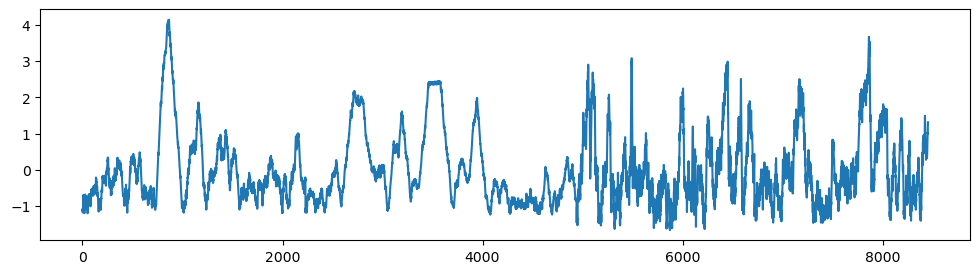

('P23', 'icuaA')
Mann_Kendall_Test                                            trend: no trend   slope: -0.00000 p-value: 0.25875
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00000 p-value: 0.63827
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00000 p-value: 0.85143


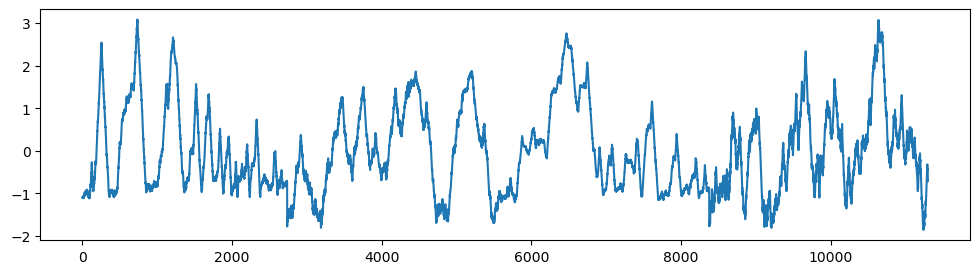

('P24', 'icuaB')
Mann_Kendall_Test                                            trend: no trend   slope:  0.00001 p-value: 0.06330
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope:  0.00001 p-value: 0.29385
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope:  0.00001 p-value: 0.81159


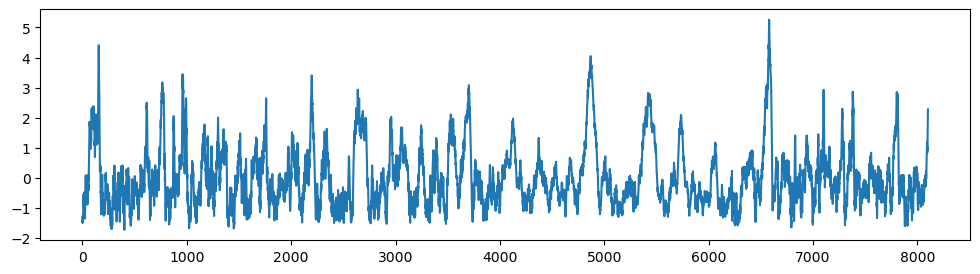

('P25', 'icuaA')
Mann_Kendall_Test                                            trend: no trend   slope: -0.00000 p-value: 0.63229
Modified_Mann_Kendall_Test_PreWhitening_Approach             trend: no trend   slope: -0.00000 p-value: 0.98249
Modified_Mann_Kendall_Test_Hamed_Rao_Approach                trend: no trend   slope: -0.00000 p-value: 0.80426


In [56]:
# check for practice effects (improvement over time)

import icua_analysis as ia
import numpy as np
import matplotlib.pyplot as plt

# check for trends using linear regression
import statsmodels.api as sm
# check for trends (practice effect)
import pymannkendall as mk
# check for auto-correlation
from statsmodels.graphics.tsaplots import plot_acf

def mannkendall_tests(x, name):
    t1 = mk.original_test(score) # doesnt correct for auto-correlation
    t2 = mk.pre_whitening_modification_test(score) # corrects for auto-correlation
    t3 = mk.hamed_rao_modification_test(score) # corrects for auto-correlation 
    ts = [t1, t2, t3]
    print(name)
    for t in ts:
        print(f"{type(t).__name__:<60} trend: {t.trend:<10} slope: {t.slope:8.5f} p-value: {t.p:.5f}")
        
demo = ia.load_demographics()
#print(demo)
for par, trial_data in ia.load_tabularised().has_eyetracking().groupby_participant():
    # sort by the order that the trials were done for each participant
    trial_order = list(demo[demo['participant'] == par].iloc[0][['T0', 'T1', 'T2', 'T3']])
    trial_data = sorted(trial_data.items(), key = lambda x: trial_order.index(x[0]))
    
    # testing for "within-trial" practice effects - that is, do individual participants improve during a trial?
    for trial, data in trial_data:
        score = data['tracking_data']['score']
        score = (score - score.mean()) / score.std() # standardize
        
        ## linear regression 
        # X = sm.add_constant(np.arange(len(score)) /  len(score)) # add y-intercept term
        # model = sm.OLS(score, X).fit()
        # print(model.summary())
        
        ## plot auto-correlation
        # plt.figure(figsize=(12,3))
        # plot_acf(score, lags=np.arange(100), ax = plt.gca())
        # plt.show()
        ## plot score
        # plt.figure(figsize=(12,3))
        # plt.gca().plot(score)
        # plt.show()
        
        # mannkendall_tests(score, (par, trial))
 
    
    # testing for "across-trial" practice effects - do individual participants improve across all trials?
    def get_score(data):
        score = data['tracking_data']['score']
        return (score - score.mean()) / score.std()
    score = np.concatenate([get_score(data) for _, data in trial_data])
    
    ## linear regression 
    # X = sm.add_constant(np.arange(len(score)) /  len(score)) # add y-intercept term
    # model = sm.OLS(score, X).fit()
    # print(model.summary())

    ## plot auto-correlation
    # plt.figure(figsize=(12,3))
    # plot_acf(score, lags=np.arange(100), ax = plt.gca())
    # plt.show()
    ## plot score
    plt.figure(figsize=(12,3))
    plt.gca().plot(score)
    plt.show()
        
    mannkendall_tests(score, (par, trial))
    
    


In [15]:
# tables results for "in failure" where this is determined by a threshold on the distance from the center of the task
import itertools
import icua_analysis as ia
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df = pd.DataFrame(columns=["participant", "trial", "mean_distance", "failure_duration", "trial_duration"])

# compute the proportion of time spent in failure
dataset = list(ia.load_tabularised().has_eyetracking())
for (par, trial), data in dataset:
    tracking_data = data['tracking_data']
    iresult = ia.compute_intervals(tracking_data['failure'], tracking_data['timestamp'], data['start_time'], data['finish_time'])
    trial_duration = data['finish_time'] - data['start_time']
    failure_duration = np.diff(iresult.intervals).sum()
    mse = tracking_data['score'].mean()
    df.loc[len(df)] = [par, trial, mse, failure_duration, trial_duration]


    #





   participant  trial  mean_distance  failure_duration  trial_duration
0          P01   icuA       6.000120          0.000000      180.000355
1          P01   icuB      14.204389          0.000000      179.992272
2          P01  icuaA       5.115697          0.000000      180.000927
3          P01  icuaB      12.382191          0.000000      179.983312
4          P02   icuA       7.617717          0.000000      180.000178
5          P02   icuB      23.306520          5.487632      179.984499
6          P02  icuaA      12.637112          0.000000      179.991923
7          P02  icuaB      30.470517         22.464982      181.112001
8          P04   icuA      10.249470          2.414032      180.030429
9          P04   icuB      25.045060         13.736832      180.000036
10         P04  icuaA       8.837707          0.000000      179.984144
11         P04  icuaB      23.821692         12.614784      180.274851
12         P05   icuA       7.578722          0.000000      180.000014
13    

In [8]:
# table for gaze and saccade over trials for each participant
import pandas as pd
import numpy as np
import icua_analysis as ia
import itertools

def compute_idata(data):
    eye_data = data['eyetracking_data']
    dt = np.diff(eye_data['timestamp'])  # get the size of each event interval
    idata = pd.DataFrame({
        'dt': dt,
        'in_task': eye_data['in_task'][:-1],
        'gaze': eye_data['gaze'][:-1]
    })
    return idata

task_order = ["F", "S", "T", "N"]
# LaTeX table beginning
latex_table = "\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|}\n"
latex_table += "\\hline\n"
latex_table += " & " + " & ".join([f"\multicolumn{{3}}{{|c}}{{{ia.get_task_properties(task)['name'].capitalize()}}}" for task in task_order]) + " \\\\ \hline \n"
latex_table += "P." + " & Look & Gaze / Prop. & Sac. / Prop."  \
                    + " & Look & Gaze / Prop. & Sac. / Prop."  \
                    + " & Look & Gaze / Prop. & Sac. / Prop."  \
                    + " & Look & Gaze  / Prop. & Sac. / Prop."  \
                    + "\\\\ \\hline \n "

for par, data in itertools.groupby(ia.load_tabularised().has_eyetracking(), lambda x: x[0][0]):
    # compute eyetracking stats for each participant (overall)
    idata = pd.concat([compute_idata(x) for _, x in data])
    latex_table += f"{par}"
    for task, group in sorted(idata.groupby('in_task'), key=lambda x : task_order.index(x[0])):
        total_looking_time = group['dt'].sum()
        total_gaze_time = group['dt'][group['gaze']].sum()
        total_saccade_time = group['dt'][np.logical_not(group['gaze'])].sum()
        # Compute proportions
        gaze_proportion = total_gaze_time / total_looking_time
        saccade_proportion = total_saccade_time / total_looking_time
        
        latex_table += f"& {total_looking_time:6.2f} & {total_gaze_time:6.2f} / {gaze_proportion:6.2f} & "
        latex_table += f"{total_saccade_time:6.2f} / {saccade_proportion:6.2f}"
            
    latex_table += "\\\\ \\hline \n"
    
# LaTeX table end
latex_table += "\\end{tabular}"

# Print the LaTeX table
print(latex_table)
    
with open("../result/eye_tracking_stats.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
 & \multicolumn{3}{|c}{Resource management} & \multicolumn{3}{|c}{System monitoring} & \multicolumn{3}{|c}{Tracking} & \multicolumn{3}{|c}{None} \\ \hline 
P. & Look & Gaze / Prop. & Sac. / Prop. & Look & Gaze / Prop. & Sac. / Prop. & Look & Gaze / Prop. & Sac. / Prop. & Look & Gaze  / Prop. & Sac. / Prop.\\ \hline 
 P01& 305.65 & 110.97 /   0.36 & 194.68 /   0.64& 137.40 &  61.76 /   0.45 &  75.65 /   0.55& 174.43 &  84.42 /   0.48 &  90.00 /   0.52&  58.69 &   2.36 /   0.04 &  56.33 /   0.96\\ \hline 
P02& 241.26 &  89.73 /   0.37 & 151.52 /   0.63& 169.99 &  87.14 /   0.51 &  82.86 /   0.49& 204.74 & 152.21 /   0.74 &  52.53 /   0.26&  51.59 &   7.98 /   0.15 &  43.62 /   0.85\\ \hline 
P04& 334.73 & 181.14 /   0.54 & 153.59 /   0.46& 142.54 &  82.22 /   0.58 &  60.32 /   0.42& 162.95 & 129.01 /   0.79 &  33.94 /   0.21&  32.19 &   0.92 /   0.03 &  31.28 /   0.97\\ \hline 
P05& 226.86 & 123.36 /   0.54 & 103.50 /   0.46&  92.63 &  

(9570,)


<IPython.core.display.Javascript object>


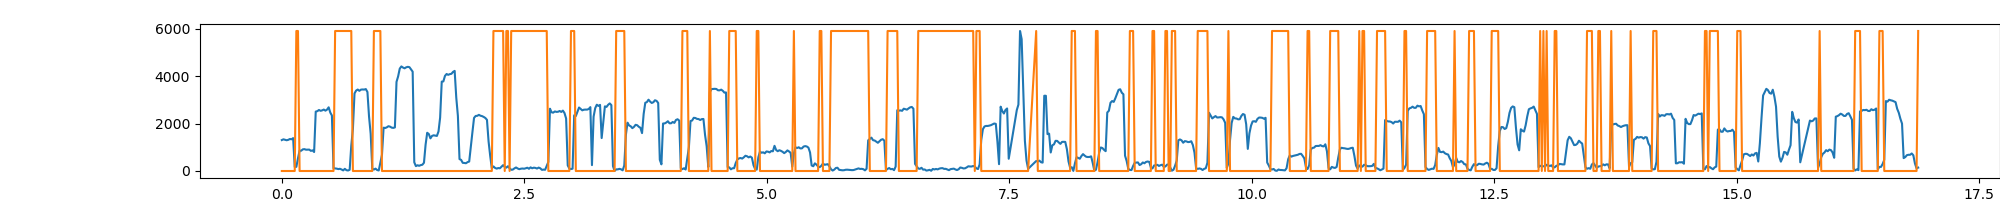

AttributeError: 'Axes' object has no attribute 'hline'

In [19]:
%matplotlib notebook
import icua_analysis as ia
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# Santity check for gaze data
for (par, trial), data in ia.load_tabularised().has_eyetracking():
    # compute gaze time for each participant/trial
    eye_data = data['eyetracking_data']
    start_time, finish_time = data['start_time'], data['finish_time']
    dt = np.diff(eye_data['timestamp'])
    print(dt.shape)
    eye_speed = ia.estimate_speed(eye_data['x'], eye_data['y'], dt)
    fig = plt.figure(figsize=(20,2))
    
    plt.subplots_adjust(left=0.1, right=1)
    N = 1000
    # check start points
    #plt.plot(eye_data['timestamp'][:N] - eye_data['timestamp'][0], eye_speed[:N])
    #plt.plot(eye_data['timestamp'][:N] - eye_data['timestamp'][0], eye_data['gaze'][:N] * eye_speed.max())
    # check end points
    plt.plot(eye_data['timestamp'][:N] - eye_data['timestamp'][0], eye_speed[:N])
    plt.plot(eye_data['timestamp'][:N] - eye_data['timestamp'][0], eye_data['gaze'][:N] * eye_speed.max())
    # looks fine.
    plt.gca().hline(200)
    break